In [1]:
from utilities import *

# Question 1 - Transformations

### create image with a name

In [ ]:
img = ICV_create_name('Hai', 'Name')
ICV_show_img(img, 'Name')

## Question 1B

### Rotate 30 degrees

In [ ]:
angle = 30

# perform rotation
r_img = ICV_rotate(img, angle)

# display output image after transformation
ICV_show_img(r_img, 'Rotated {}'.format(angle))
cv2.imwrite('figures/transformations/rotate{}.jpg'.format(angle), r_img)

### Rotate 60 degrees

In [ ]:
angle = 60

# perform rotation
r_img = ICV_rotate(img, angle)

# display output image
ICV_show_img(r_img, 'Rotated {}'.format(angle))
cv2.imwrite('figures/transformations/rotate{}.jpg'.format(angle), r_img)

### Rotate 120 degrees

In [ ]:
angle = 120

# perform rotation
r_img = ICV_rotate(img, angle)

# display output image
ICV_show_img(r_img, 'Rotated {}'.format(angle))
cv2.imwrite('figures/transformations/rotate{}.jpg'.format(angle), r_img)

### Rotate -50 degrees

In [ ]:
angle = -50

# perform rotation
r_img = ICV_rotate(img, angle)

# display output image
ICV_show_img(r_img, 'Rotated {}'.format(angle))
cv2.imwrite('figures/transformations/rotate{}.jpg'.format(angle), r_img)

### Skew 10 degrees

In [ ]:
angle = 10

# perform skewing
skewed_img = ICV_skew(img, angle)

# display output image
ICV_show_img(skewed_img, 'Skewed')
cv2.imwrite('figures/transformations/skew{}.jpg'.format(angle), skewed_img)

### Skew 40 degrees

In [ ]:
angle = 40

# perform skewing
skewed_img = ICV_skew(img, angle)

# display output image
ICV_show_img(skewed_img, 'Skewed')
cv2.imwrite('figures/transformations/skew{}.jpg'.format(angle), skewed_img)

### Skew 60 degrees

In [ ]:
angle = 60

# perform skewing
skewed_img = ICV_skew(img, angle)

# display output image
ICV_show_img(skewed_img, 'Skewed')
cv2.imwrite('figures/transformations/skew{}.jpg'.format(angle), skewed_img)

## Question 1C

### Rotate 20 degrees then skew 50 degrees

In [ ]:
# perform rotation
new_img = ICV_rotate(img, 20)

# perform skewing on the new image
new_img = ICV_skew(new_img, 50)

# display output image
ICV_show_img(new_img, 'rotate20_skew50.jpg')
cv2.imwrite('figures/transformations/rotate20_skew50.jpg', new_img)

### Skew 50 degrees then rotate 20 degrees

In [ ]:
# perform skewing
new_img = ICV_skew(img, 50)

# perform rotation
new_img = ICV_rotate(new_img, 20)

# display output image
ICV_show_img(new_img, 'skew50_rotate20.jpg')
cv2.imwrite('figures/transformations/skew50_rotate20.jpg', new_img)

# Question 2 - Convolutions

In [ ]:
img = cv2.imread('Dataset/DatasetA/car-1.jpg')

## Question 2B

### Initialisation of kernel for Average Intensity Convolution

In [ ]:
# kernel for computing average of neighbors
kernel_mean = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

# normalise
kernel_mean = kernel_mean/kernel_mean.size

# apply convolution
mean_img = ICV_apply_kernel(img, kernel_mean)
ICV_show_img(mean_img, 'Mean Filter')
cv2.imwrite('figures/convolutions/average_intensity.jpg', mean_img)

## Question 2C

### Initialisation of Kernel A and kernel B

In [ ]:
# kernel A
kernel_A = np.array([
    [1, 2, 1],
    [2, 4, 2],    
    [1, 2, 1]
])

# normalise kernel A
sum_A = np.sum(kernel_A)
kernel_A = kernel_A/sum_A

# kernel B
kernel_B = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])

### Apply Kernel A

In [ ]:
# apply convolution with kernel A
A_img = ICV_apply_kernel(img, kernel_A)
ICV_show_img(A_img, 'Kernel A')
cv2.imwrite('figures/convolutions/img_A.jpg', A_img)

### Apply Kernel B

In [ ]:
# apply convolution with kernel B
B_img = ICV_apply_kernel(img, kernel_B)
ICV_show_img(B_img, 'Kernel B')
cv2.imwrite('figures/convolutions/img_B.jpg', B_img)

## Question 2D

### Kernel A followed by kernel A

In [ ]:
# apply convolution with Kernel A
A_A = ICV_apply_kernel(img, kernel_A)

# apply convolution with kernel A for a second time
A_A = ICV_apply_kernel(A_A, kernel_A)
ICV_show_img(A_A, 'img_AA')
cv2.imwrite('figures/convolutions/img_AA.jpg', A_A)

### Kernel A followed by kernel B

In [ ]:
# apply convolution with kernel A
A_B = ICV_apply_kernel(img, kernel_A)

# apply convolution with kernel B
A_B = ICV_apply_kernel(A_B, kernel_B)
ICV_show_img(A_B, 'img_AB')
cv2.imwrite('figures/convolutions/img_AB.jpg', A_B)

### Kernel B followed by kernel A

In [ ]:
# apply convolution with kernel B
B_A = ICV_apply_kernel(img, kernel_B)

# apply convolution with kernel A
B_A = ICV_apply_kernel(B_A, kernel_A)
ICV_show_img(B_A, 'img_BA')
cv2.imwrite('figures/convolutions/img_BA.jpg', B_A)

# Question 3 - Histogram and Video Segmentation

## Question 3A

In [ ]:
path = 'Dataset/DatasetB.avi'

### Get frames from video sequence

In [ ]:
frames = ICV_get_frames(path, 1)

### Save the frames

In [ ]:
cv2.imwrite('figures/histogram/first_frame.png', frames[0])
cv2.imwrite('figures/histogram/second_frame.png', frames[1])
cv2.imwrite('figures/histogram/last_frame.png', frames[len(frames)-1])

### Create histograms for consecutive and non-consecutive frames in a video sequence

In [ ]:
# generate histogram for first frame of the video sequence
first_histogram = ICV_create_hist(frames[0])

# plot and save the histogram for the first frame
ICV_plot_histogram(first_histogram, 'figures/histogram/first_histogram.png')

# generate histogram for second frame of the video sequence
second_histogram = ICV_create_hist(frames[1])

# plot and save the histogram for the second frame
ICV_plot_histogram(second_histogram, 'figures/histogram/second_histogram.png')

# generate histogram for last frame of the video sequence
last_histogram = ICV_create_hist(frames[len(frames)-1])

# plot and save the histogram for the last frame
ICV_plot_histogram(last_histogram, 'figures/histogram/last_histogram.png')

## Question 3B

### Histogram intersection of non-consecutive frames

In [ ]:
# compute histogram intersection for first frame and last frame
non_consecutive_intersection = ICV_hist_intersection(first_histogram, last_histogram)
non_consecutive_intersection

### Histogram intersection of consecutive frames

In [ ]:
# compute histogram intersection for first frame and second frame
consecutive_intersection = ICV_hist_intersection(first_histogram, second_histogram)
consecutive_intersection

### Histogram intersections of a video sequence

In [ ]:
# compute histogram intersections for all colour channels in the video sequence over time
blue_intersections = ICV_get_intersections(frames, 0)
green_intersections = ICV_get_intersections(frames, 1)
red_intersections = ICV_get_intersections(frames, 2)

### Normalized histogram intersections

In [ ]:
number_of_pixels = np.array(frames).shape[1] * np.array(frames).shape[2]

# normalize the intersections obtained from previous cell
blue_normalized = ICV_normalize_intersections(blue_intersections, number_of_pixels)
red_normalized = ICV_normalize_intersections(red_intersections, number_of_pixels)
green_normalized = ICV_normalize_intersections(green_intersections, number_of_pixels)


### Bar graph of histogram intersections

In [ ]:
ICV_plot_intersections(frames, (blue_intersections, green_intersections, red_intersections), 'bar', 'figures/histogram/video_intersection_bar.png')

### Line graph of normalized histogram intersections

In [ ]:
ICV_plot_intersections(frames, (blue_intersections, green_intersections, red_intersections), 'line', 'figures/histogram/video_intersection_line.png')

### Line graph of histogram intersections

In [ ]:
ICV_plot_intersections(frames, (blue_normalized, green_normalized, red_normalized), 'bar', 'figures/histogram/video_intersection_normalized_bar.png')

### Line graph of normalized histogram intersections

In [ ]:
ICV_plot_intersections(frames, (blue_normalized, green_normalized, red_normalized), 'line', 'figures/histogram/video_intersection_normalized_line.png')

# Question 4 - Texture Descriptors and Classification

### Set the window size and the index of the window to be used

In [2]:
window_size = 32
index = 0

### Car 3 - obtain feature descriptors and global descriptor

In [4]:
# set the car image to use
car = 3
img = cv2.imread('Dataset/DatasetA/car-{}.jpg'.format(car))
windows = ICV_to_windows(img, window_size)

# get feature descriptors and windows after applying LBP
fd, lbp_windows = ICV_get_fd(img, window_size)

# normalise the feature descriptors
fd = np.array(fd) / ((window_size)*(window_size))

# get global descriptor
gd_car_3 = ICV_get_gd(fd)


ICV_show_img(windows[index], '{}x{} window of original car-{}'.format(window_size, window_size, car))
cv2.imwrite('figures/texture/{}x{} window of original car-{}.jpg'.format(window_size, window_size, car), windows[index])

ICV_show_img(lbp_windows[index], '{}x{} window of LBP car-{}'.format(window_size, window_size, car))
cv2.imwrite('figures/texture/{}x{} window of LBP car-{}.jpg'.format(window_size, window_size, car), lbp_windows[index])

True

### Car 3 - first window feature descriptor histogram

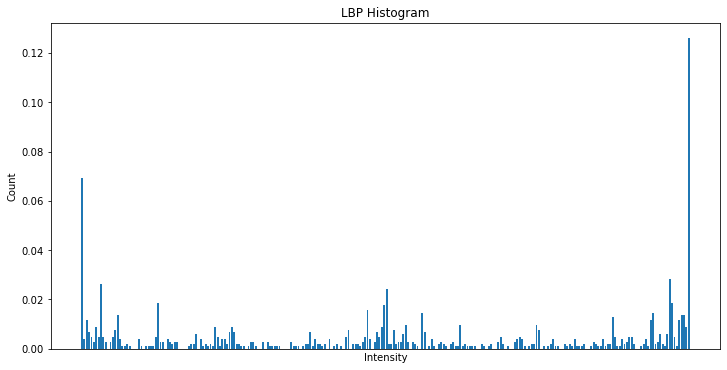

In [5]:
lbp_hist = fd[index]

x = np.arange(0, 256)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x, lbp_hist)
ax.set_xticks(np.arange(len(x)))
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,     
    top=False,         
    labelbottom=False) 
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.title('LBP Histogram')
fig.savefig('figures/texture/{}x{} LBP histogram of car-{}'.format(window_size, window_size, car))

### Car 3 - global descriptor histogram

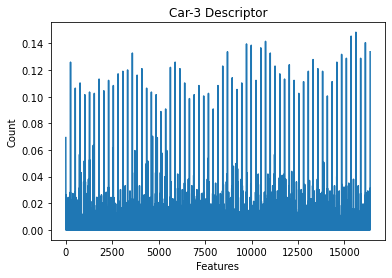

In [6]:
plt.ylabel('Count')
plt.xlabel('Features')
plt.title('Car-3 Descriptor')
plt.plot(gd_car_3)
plt.savefig('figures/texture/{}x{} car-3 descriptor.png'.format(window_size, window_size))

### Car 2 - obtain feature descriptors and global descriptor

In [7]:
car = 2
img = cv2.imread('Dataset/DatasetA/car-{}.jpg'.format(car))
windows = ICV_to_windows(img, window_size)

# get feature descriptors and windows after applying LBP
fd, lbp_windows = ICV_get_fd(img, window_size)
fd = np.array(fd) / ((window_size)*(window_size))

# get global descriptor
gd_car_2 = ICV_get_gd(fd)

ICV_show_img(windows[index], '{}x{} window of original car-{}'.format(window_size, window_size, car))
cv2.imwrite('figures/texture/{}x{} window of original car-{}.jpg'.format(window_size, window_size, car), windows[index])

ICV_show_img(lbp_windows[index], '{}x{} window of LBP car-{}'.format(window_size, window_size, car))
cv2.imwrite('figures/texture/{}x{} window of LBP car-{}.jpg'.format(window_size, window_size, car), lbp_windows[index])

True

### Car 2 - first window feature descriptor histogram

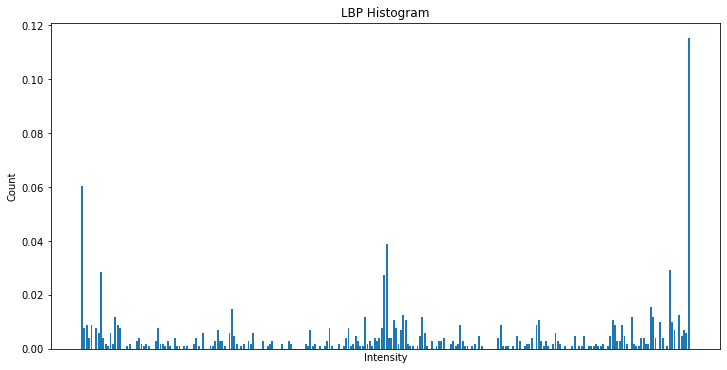

In [8]:
lbp_hist = fd[index]

x = np.arange(0, 256)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x, lbp_hist)
ax.set_xticks(np.arange(len(x)))
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False) 
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.title('LBP Histogram')
fig.savefig('figures/texture/{}x{} LBP histogram of car-{}'.format(window_size, window_size, car))

### Intersection of car 3 and car 2 global descriptors

In [9]:
intersection = ICV_hist_intersection(gd_car_3, gd_car_2)
intersection

46.5361328125

### Car 1 - obtain feature descriptors and global descriptor

In [10]:
car = 1
img = cv2.imread('Dataset/DatasetA/car-{}.jpg'.format(car))
windows = ICV_to_windows(img, window_size)

# get feature descriptors and windows after applying LBP
fd, lbp_windows = ICV_get_fd(img, window_size)
fd = np.array(fd) / ((window_size)*(window_size))

# get global descriptor
gd_car_1 = ICV_get_gd(fd)

ICV_show_img(windows[index], '{}x{} window of original car-{}'.format(window_size, window_size, car))
cv2.imwrite('figures/texture/{}x{} window of original car-{}.jpg'.format(window_size, window_size, car), windows[index])

ICV_show_img(lbp_windows[index], '{}x{} window of LBP car-{}'.format(window_size, window_size, car))
cv2.imwrite('figures/texture/{}x{} window of LBP car-{}.jpg'.format(window_size, window_size, car), lbp_windows[index])

True

### Car 1 - first window feature descriptor histogram

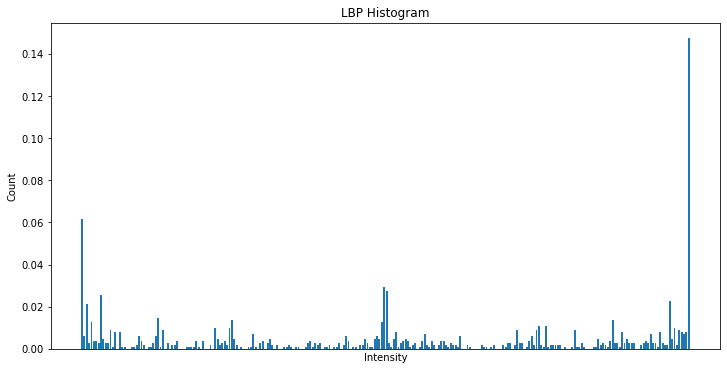

In [11]:
lbp_hist = fd[index]

x = np.arange(0, 256)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x, lbp_hist)
ax.set_xticks(np.arange(len(x)))
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,     
    top=False,         
    labelbottom=False) 
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.title('LBP Histogram')
fig.savefig('figures/texture/{}x{} LBP histogram of car-{}'.format(window_size, window_size, car))

### Intersection of car 3 and car 1 global descriptors

In [12]:
intersection = ICV_hist_intersection(gd_car_3, gd_car_1)
intersection

45.8671875

### Face 1 - feature descriptors and global descriptor

In [13]:
face = 1
img = cv2.imread('Dataset/DatasetA/face-{}.jpg'.format(face))
windows = ICV_to_windows(img, window_size)

# get feature descriptors and windows after applying LBP
fd, lbp_windows = ICV_get_fd(img, window_size)
fd = np.array(fd) / ((window_size)*(window_size))

# get global descriptor
gd_face_1 = ICV_get_gd(fd)

ICV_show_img(windows[index], '{}x{} window of original face-{} image'.format(window_size, window_size, face))
cv2.imwrite('figures/texture/{}x{} window of original face-{} image.jpg'.format(window_size, window_size, face), windows[index])

ICV_show_img(lbp_windows[index], '{}x{} window of LBP face-{} image'.format(window_size, window_size, face))
cv2.imwrite('figures/texture/{}x{} window of LBP face-{} image.jpg'.format(window_size, window_size, face), lbp_windows[index])

True

### Face 1 - first window feature descriptor histogram

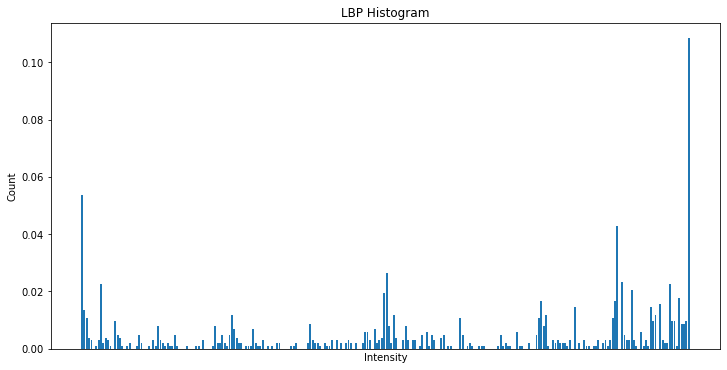

In [14]:
lbp_hist = fd[index]

x = np.arange(0, 256)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x, lbp_hist)
ax.set_xticks(np.arange(len(x)))
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,     
    top=False,         
    labelbottom=False) 
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.title('LBP Histogram')
fig.savefig('figures/texture/{}x{} LBP histogram of car-{}'.format(window_size, window_size, car))

### Face 1 - global descriptor histogram

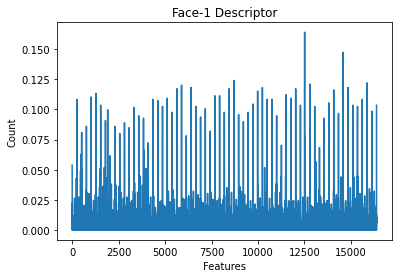

In [15]:
plt.ylabel('Count')
plt.xlabel('Features')
plt.title('Face-1 Descriptor')
plt.plot(gd_face_1)
plt.savefig('figures/texture/{}x{} face-1 descriptor.png'.format(window_size, window_size))

### Intersection of car 3 and face 1 global descriptors

In [16]:
intersection = ICV_hist_intersection(gd_car_3, gd_face_1)
intersection

42.341796875

### Face 2 feature descriptors and global descriptor

In [17]:
face = 2
img = cv2.imread('Dataset/DatasetA/face-{}.jpg'.format(face))
windows = ICV_to_windows(img, window_size)

# get feature descriptors and windows after applying LBP
fd, lbp_windows = ICV_get_fd(img, window_size)
fd = np.array(fd) / ((window_size)*(window_size))

# get global descriptor
gd_face_2 = ICV_get_gd(fd)

ICV_show_img(windows[index], '{}x{} window of original face-{}'.format(window_size, window_size, face))
cv2.imwrite('figures/texture/{}x{} window of original face-{}.jpg'.format(window_size, window_size, face), windows[index])

ICV_show_img(lbp_windows[index], '{}x{} window of LBP face-{}'.format(window_size, window_size, face))
cv2.imwrite('figures/texture/{}x{} window of LBP face-{}.jpg'.format(window_size, window_size, face), lbp_windows[index])

True

### Face 2 - first window feature descriptor histogram

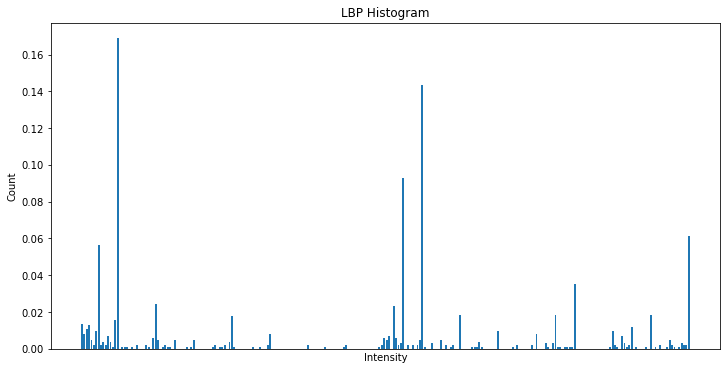

In [18]:
lbp_hist = fd[index]

x = np.arange(0, 256)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x, lbp_hist)
ax.set_xticks(np.arange(len(x)))
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,     
    top=False,         
    labelbottom=False) 
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.title('LBP Histogram')
fig.savefig('figures/texture/{}x{} LBP histogram of car-{}'.format(window_size, window_size, car))

### Intersection of car 3 and face 2 global descriptors

In [19]:
intersection = ICV_hist_intersection(gd_car_3, gd_face_2)
intersection

35.8544921875

### Face 3 feature descriptors and global descriptor

In [20]:
face = 3
img = cv2.imread('Dataset/DatasetA/face-{}.jpg'.format(face))
windows = ICV_to_windows(img, window_size)

# get feature descriptors and windows after applying LBP
fd, lbp_windows = ICV_get_fd(img, window_size)
fd = np.array(fd) / ((window_size)*(window_size))

# get global descriptor
gd_face_3 = ICV_get_gd(fd)

ICV_show_img(windows[index], '{}x{} window of original face-{}'.format(window_size, window_size, face))
cv2.imwrite('figures/texture/{}x{} window of original face-{}.jpg'.format(window_size, window_size, face), windows[index])

ICV_show_img(lbp_windows[index], '{}x{} window of LBP face-{}'.format(window_size, window_size, face))
cv2.imwrite('figures/texture/{}x{} window of LBP face-{}.jpg'.format(window_size, window_size, face), lbp_windows[index])

True

### Face 3 - first window feature descriptor histogram

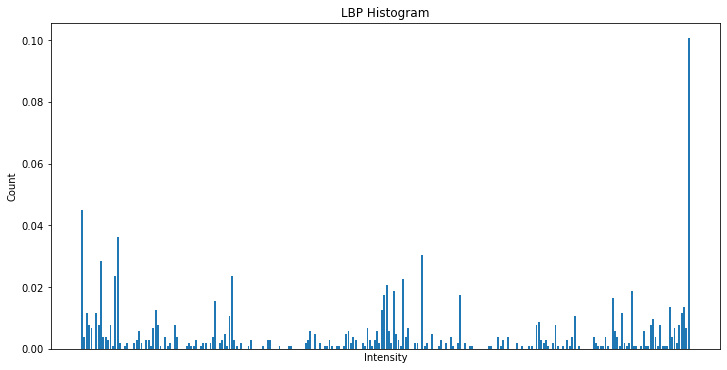

In [21]:
lbp_hist = fd[index]

x = np.arange(0, 256)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x, lbp_hist)
ax.set_xticks(np.arange(len(x)))
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,     
    top=False,         
    labelbottom=False) 
plt.ylabel('Count')
plt.xlabel('Intensity')
plt.title('LBP Histogram')
fig.savefig('figures/texture/{}x{} LBP histogram of car-{}'.format(window_size, window_size, car))

### Intersection of car 3 and face 3 global descriptors

In [22]:
intersection = ICV_hist_intersection(gd_car_3, gd_face_3)
intersection

42.2041015625

# Object Segmentation and Counting

## Question 5A

In [23]:
path = 'Dataset/DatasetC.avi'

In [24]:
# set the threshold
threshold = 50

In [25]:
# get frames from video sequence
frames = ICV_get_frames(path, 0)
ICV_show_img(frames[0], '1')
cv2.imwrite('figures/object_segmentation/first_frame.png', frames[0])
cv2.imwrite('figures/object_segmentation/middle_frame.png', frames[int(len(frames)/2)])
cv2.imwrite('figures/object_segmentation/last_frame.png', frames[len(frames)-1])

True

In [26]:
ICV_play_video(frames)

### Frame differencing with first frame as reference frame

In [27]:
# frame differencing
segmented_frames = ICV_compute_segmentation(frames, frames[0])
ICV_play_video(segmented_frames)
cv2.imwrite('figures/object_segmentation/first_frame_segmented.png', segmented_frames[0])
cv2.imwrite('figures/object_segmentation/middle_frame_segmented.png', segmented_frames[int(len(frames)/2)])
cv2.imwrite('figures/object_segmentation/last_frame_segmented.png', segmented_frames[len(segmented_frames)-1])

True

### Applying classification threshold

In [28]:
# classification threshold
classified_frames = ICV_threshold_classification(segmented_frames, threshold)
ICV_play_video(classified_frames)
cv2.imwrite('figures/object_segmentation/first_frame_classified.png', classified_frames[0])
cv2.imwrite('figures/object_segmentation/middle_frame_classified.png', classified_frames[int(len(frames)/2)])
cv2.imwrite('figures/object_segmentation/last_frame_classified.png', classified_frames[len(classified_frames)-1])

True

## Question 5B

### Frame differencing with previous frame as reference frame

In [29]:
# frame differencing from previous frame
segmented_from_previous = ICV_segment_previous_frame(frames)
ICV_play_video(segmented_from_previous)
cv2.imwrite('figures/object_segmentation/segmented_from_previous_original.png', frames[1])
cv2.imwrite('figures/object_segmentation/segmented_from_previous_original2.png', frames[len(frames)-1])
cv2.imwrite('figures/object_segmentation/segmented_from_previous.png', segmented_from_previous[1])
cv2.imwrite('figures/object_segmentation/segmented_from_previous2.png', segmented_from_previous[len(frames)-1])

True

### Applying clasification threshold

In [30]:
# classification threshold
classified_from_previous = ICV_threshold_classification(segmented_from_previous, threshold)
ICV_play_video(classified_from_previous)
cv2.imwrite('figures/object_segmentation/classified_from_previous.png', classified_from_previous[1])
cv2.imwrite('figures/object_segmentation/classified_from_previous2.png', classified_from_previous[len(frames)-1])

True

## Question 5C

### Generate Background

In [32]:
# get background
background = ICV_get_background(frames)
ICV_show_img(background, 'bg')
cv2.imwrite('figures/object_segmentation/background.png', background)

True

## Question 5D

### Compute frame differencing with background as reference frame

In [33]:
# frame differencing with respect to background
segmented_from_background = ICV_compute_segmentation(frames, background)
classified_from_background = ICV_threshold_classification(segmented_from_background, threshold)
cv2.imwrite('figures/object_segmentation/first_frame_from_background.png', classified_from_background[0])

True

### Interpolate the blobs to remove noise

In [34]:
interpolate_level = 7

interpolated_frames = ICV_interpolate_frames(classified_from_background, interpolate_level)
ICV_show_img(interpolated_frames[0], '1')
cv2.imwrite('figures/object_segmentation/first_frame_interpolated.png', interpolated_frames[0])
cv2.imwrite('figures/object_segmentation/last_frame_interpolated.png', interpolated_frames[len(interpolated_frames)-1])

True

### Display the interpolated image of blobs

In [35]:
ICV_show_img(interpolated_frames[1], '1')

### Object count throughout the video sequence



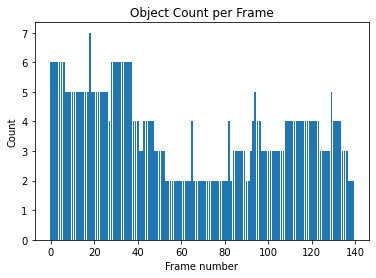

In [36]:
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt

object_count = []
for frame in interpolated_frames:
    im = ndimage.gaussian_filter(frame, 1)
    blobs, count = ndimage.label(im)
    object_count.append(count)

x = np.arange(0, len(object_count))
plt.bar(x, object_count)
plt.xlabel('Frame number')
plt.ylabel('Count')
plt.title('Object Count per Frame')
plt.savefig('figures/object_segmentation/object_count_graph.png')

### Label objects BEFORE interpolation

Number of blobs: 83


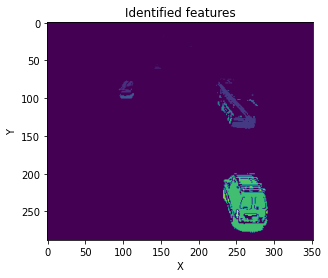

In [37]:
blobs, count = ndimage.label(classified_from_background[0])
print('Number of blobs:', count)

plt.imshow(blobs)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Identified features')
plt.savefig('figures/object_segmentation/blob_count_original.png')
plt.show()

### Label objects AFTER interpolation

Number of blobs: 6


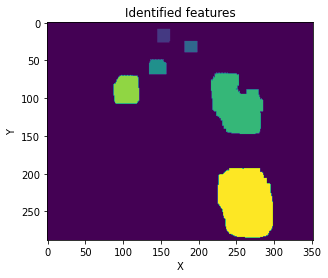

In [38]:
blobs, count = ndimage.label(interpolated_frames[0])
print('Number of blobs:', count)

plt.imshow(blobs)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Identified features')
plt.savefig('figures/object_segmentation/blob_count_interpolated.png')
plt.show()